# Fundamentos de analítica 2 (clase 2)

## Diego Fernando Agudelo 
## Universidad ICESI 
## diegoagudelo30@gmail.com

## **1. Carga de paquetes**

In [1]:
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta

## **2. Carga de datos**

Vamos a usar los datos del libro para hacer las diferentes pruebas.

In [2]:
data = pd.read_csv(r"https://raw.githubusercontent.com/alfa7g7/Fundamentos-analitica-II/main/Clase%202/Ejercicio%20en%20clase%20(ya%20se%20encuentran%20las%20series%20Y1%20y%20Y2%20disponibles)-20240809/data.csv")
data.head()

,Unnamed: 0,y1,y2
0,1,0.833733,-0.415429
1,2,-0.276048,-0.094647
2,3,-0.355002,-0.609143
3,4,0.087487,-0.967878
4,5,2.252256,-1.098378


(100, 3)


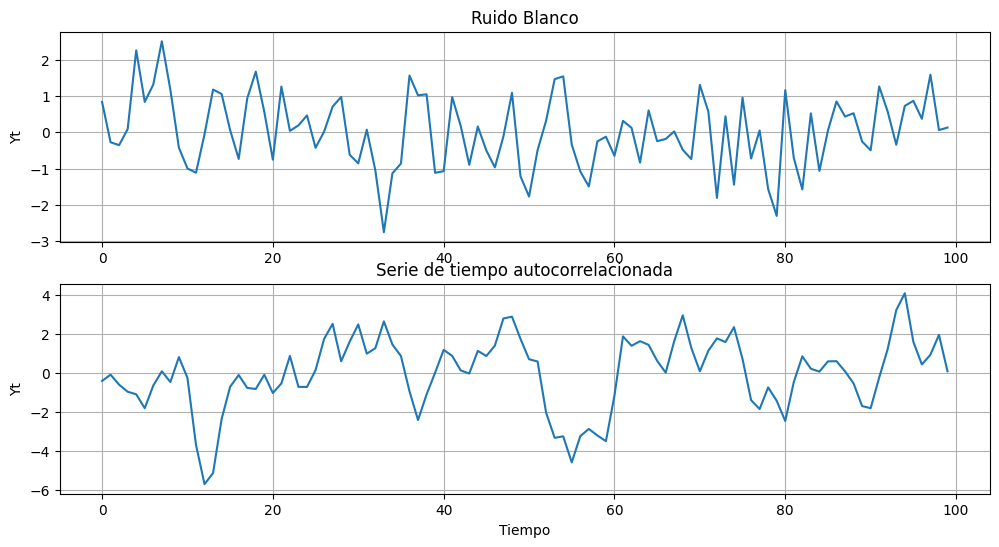

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Ruido Blanco")
plt.ylabel("Yt")
plt.plot(data[["y1"]])
plt.grid()

plt.subplot(2,1, 2)
plt.title("Serie de tiempo autocorrelacionada")
plt.xlabel("Tiempo")
plt.ylabel("Yt")
plt.plot(data[["y2"]])
plt.grid()

plt.show()

## **3. Autocorrelación**

Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

$H{0}: ρ = 0$ (Es decir no hay autocorrelación) 

$H{1}: ρ \not= 0$ (Es decir hay autocorrelación)

Rechazo $H{0}$ cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un $α$=0.05 ($α$ = nivel de significancia).


In [4]:
signo = data.y1>0

In [5]:
runstest_1samp(signo, correction=False)

(-0.7445593771613326, 0.4565381333591594)

El segundo valor corresponde al p-valor=0.4565, por lo tanto considerando un $α$=0.05, los resultados obtenidos no permiten rechazar la hipótesis nula, es decir, la serie y1 parece comportarse como un ruido blanco, **No presenta autocorrelación**. 

In [6]:
signo2 = data.y2>0

In [7]:
runstest_1samp(signo2, correction=False)

(-6.599750073368524, 4.1185149037669715e-11)

Los resultados permiten rechazar la no autocorrelación (p-value=0) y por lo tanto se puede concluir que existe autocorrelación en la serie, es decir, con esta prueba la serie y2 no parece comportarse como ruido blanco.

Este análisis debe complementarse con otras pruebas como la prueba de Box-Pierce y la modificación de Ljung-Box para muestras pequeñas.

In [8]:
# prueba de Box-Pierce y la modificación de Ljung-Box 
sm.stats.acorr_ljungbox(data.y1, lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,5.411117,0.020009,5.251967,0.021922


Con el resultado anterior rechazamos la hipótesis nula de no autocorrelación para el primer rezago, lo ideal antes de tomar la decisión 
Es probar por lo menos los primeros 20 rezagos.

In [9]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.y1, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,5.411117,0.020009,5.251967,0.021922,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,5.625488,0.060040,5.457931,0.065287,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,5.625680,0.131312,5.458113,0.141165,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,6.065129,0.194337,5.871712,0.208936,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,6.380041,0.270975,6.165013,0.290492,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
6,7.951787,0.241657,7.613485,0.267809,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
7,8.121189,0.322029,7.767940,0.353501,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
8,8.789054,0.360403,8.370327,0.398156,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
9,8.801954,0.455753,8.381837,0.496171,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
10,13.472400,0.198445,12.502818,0.252812,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


En el anterior data frame las columnas lb_ho y bp_ho nos permiten entender la decisión a tomar al usar las dos pruebas, a pesar de que el primer rezago parece presentar autocorrelación, en general para los demás rezagos no se observa el mismo comportamiento, por lo tanto se puede concluir que la serie parece comportarse como un ruido blanco, **No presenta autocorrelación**.

In [10]:
Resul_lb_bp_y2 = sm.stats.acorr_ljungbox(data.y2, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp_y2["lb_ho"] = np.where(Resul_lb_bp_y2['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp_y2["bp_ho"] = np.where(Resul_lb_bp_y2['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp_y2

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,62.298996,2.950756e-15,60.466672,7.483484e-15,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,84.457955,4.572862e-19,81.756653,1.765096e-18,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,92.384452,6.734999e-20,89.294596,3.105002e-19,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,94.146987,1.730402e-19,90.953453,8.259318e-19,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,94.230352,8.669536e-19,91.031096,4.080227e-18,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,94.267474,3.927667e-18,91.065307,1.820145e-17,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,94.642806,1.373092e-17,91.407521,6.357527e-17,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,97.030158,1.724917e-17,93.560819,8.784214e-17,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,101.631263,7.357682e-18,97.665727,4.662276e-17,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,105.213397,4.906761e-18,100.826433,3.723204e-17,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En la serie y2 si es muy contundente la decisión en los primeros 20 rezagos, es decir, la serie y2 no parece comportarse como un ruido blanco, **Si presenta autocorrelación**.

### **4. Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

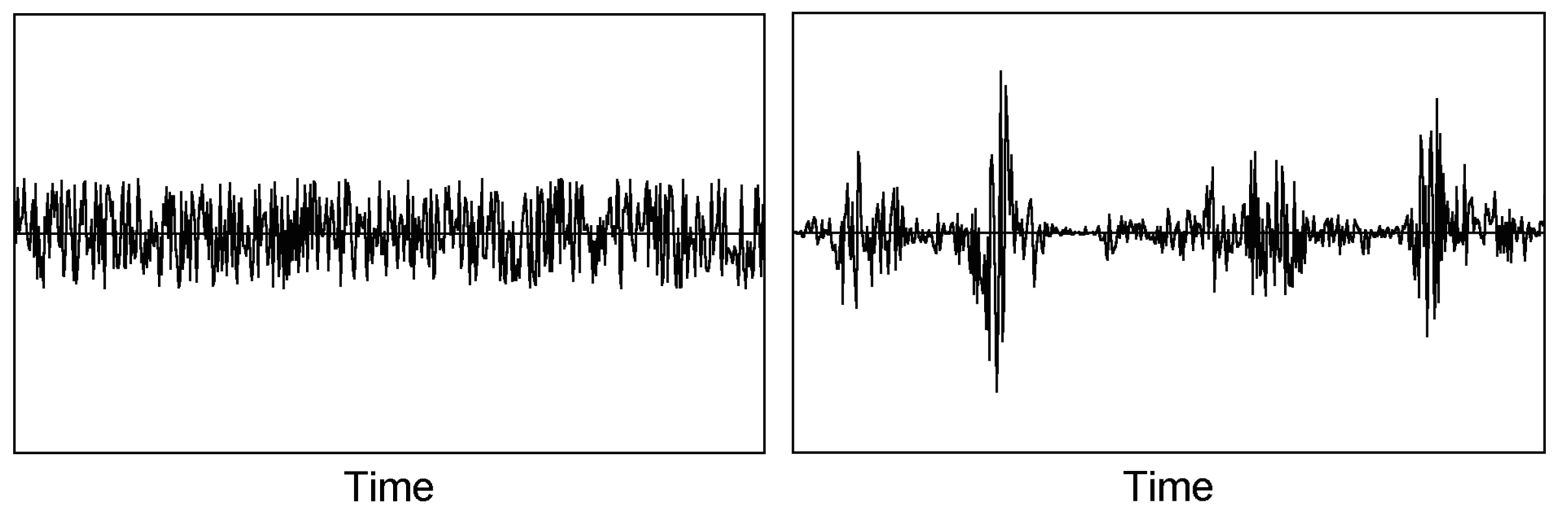



In [11]:
sm.stats.acorr_ljungbox((data.y1-data.y1.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.572389,0.449311,0.555554,0.456057
2,0.915452,0.632721,0.885164,0.642376
3,6.285833,0.098502,5.992291,0.111986
4,6.405496,0.170843,6.104914,0.191449
5,7.434561,0.190275,7.063357,0.215971
6,7.732158,0.258390,7.337614,0.290750
7,7.887708,0.342600,7.479439,0.380721
8,9.767181,0.281749,9.174650,0.327778
9,11.265804,0.257929,10.511657,0.310671
10,11.776692,0.300280,10.962440,0.360452


Los resultados del la Tabla anterior, no permiten rechazar la nula de un comportamiento homoscedástico(no auto-correlación de las varianzas) y por tanto no hay comportamiento ARCH o GARCH.

### **5. Normalidad**
Finalmente, podemos evaluar si la serie sigue una distribución normal o no. Noten que esto no es necesario para ser ruido blanco, solo para ser ruido blanco gaussiano. Primero hagamos un análisis gráfico empleando las siguientes lineas de código.

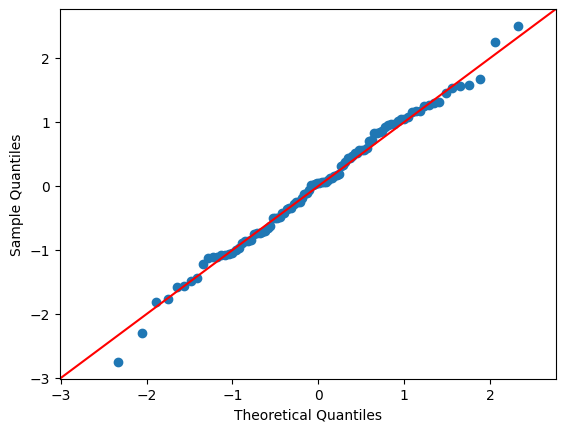

In [12]:
sm.qqplot(data.y1, line ='45')
py.show()

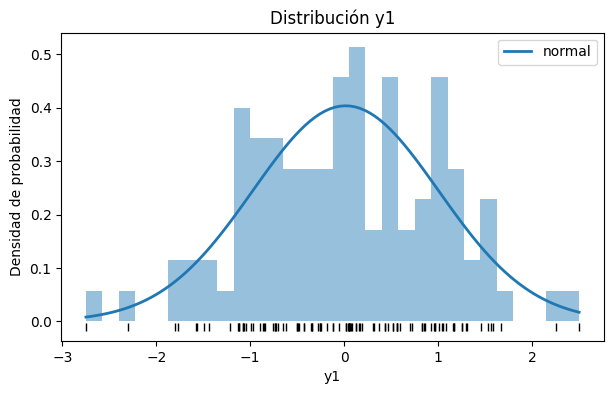

In [13]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(data.y1)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(data.y1), max(data.y1), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=data.y1, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(data.y1, np.full_like(data.y1, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución y1')
ax.set_xlabel('y1')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [14]:
stats.shapiro(data.y1)


ShapiroResult(statistic=0.9937945604324341, pvalue=0.9310362339019775)

In [15]:
stats.jarque_bera(data.y1)

SignificanceResult(statistic=0.3145303213003905, pvalue=0.8544774549782629)

Para ambas pruebas, no se puede rechazar la hipótesis de que los datos provienen de una distribución normal. Así, parece ser que la serie y1 proviene de un proceso ruido blanco gaussiano.

### **6. Tendencia Lineal**

In [16]:
data = pd.read_excel(r'https://github.com/alfa7g7/Fundamentos-analitica-II/raw/main/Clase%201/Ejercicio%20en%20clase.-20240802/datosEmpleo.xlsx', index_col='mes', parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [ ]:
# Genero mi train con toda la información para que los futuros dummies no se me enloquezcan


In [26]:
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     4768.
Date:                Sat, 10 Aug 2024   Prob (F-statistic):          3.78e-150
Time:                        11:42:30   Log-Likelihood:                -1543.4
No. Observations:                 220   AIC:                             3091.
Df Residuals:                     218   BIC:                             3097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6953.2351     36.621    189.870      0.0

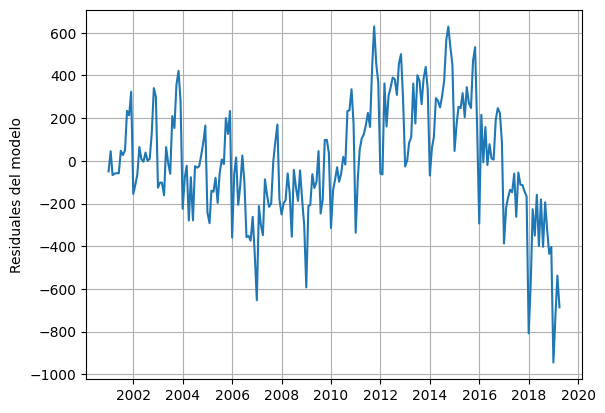

In [27]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

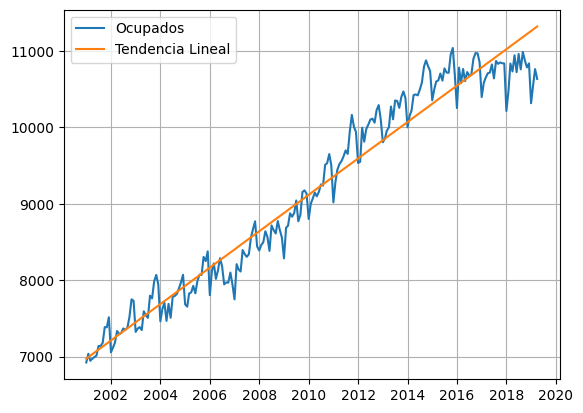

In [28]:
plt.plot(y,label="Ocupados")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [29]:
h=6 # pongo h=6 y no 12 porque son 6 meses
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(x_for)


In [30]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11338.111638  10799.800067  11876.423210
1    11357.952709  10819.575011  11896.330406
2    11377.793779  10839.349368  11916.238190
3    11397.634849  10859.123137  11936.146561
4    11417.475919  10878.896319  11956.055519
5    11437.316989  10898.668914  11975.965064


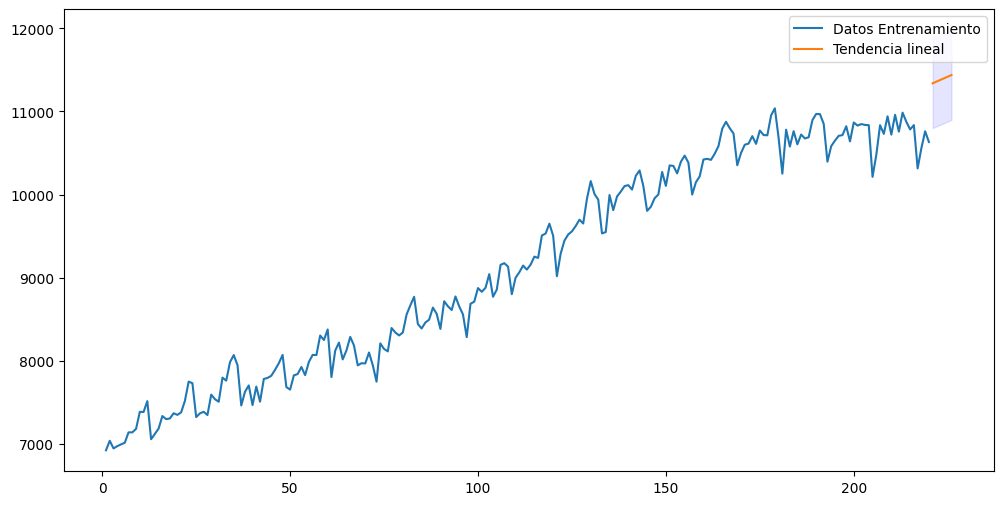

In [31]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia lineal")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()


### **7. Tendencia Cuadratica**

In [23]:
y = data["TD_13ciudades"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2
X = sm.add_constant(data[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:          TD_13ciudades   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     441.2
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           3.50e-77
Time:                        10:32:01   Log-Likelihood:                -361.04
No. Observations:                 220   AIC:                             728.1
Df Residuals:                     217   BIC:                             738.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.0036      0.257     74.047      0.0

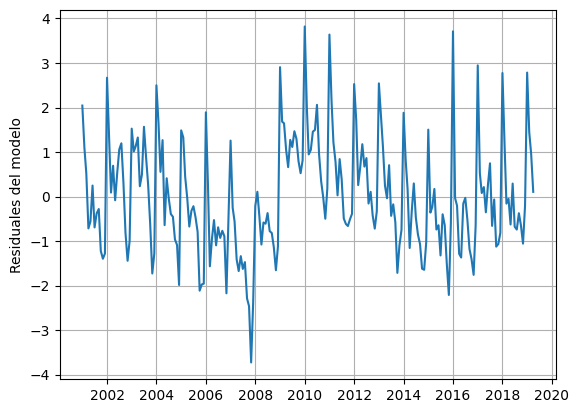

In [24]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

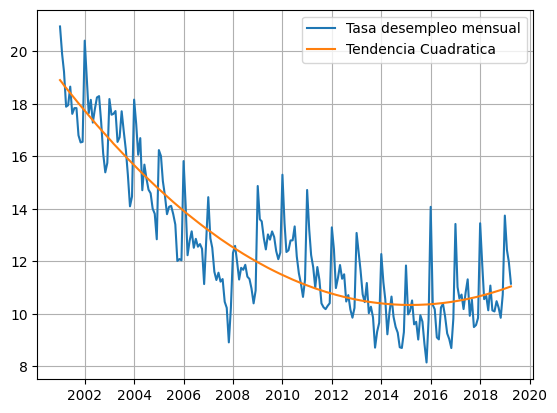

In [25]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [26]:
h=12
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [27]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

    Point_forecast  lower_95   upper_95
0        11.067921  8.538615  13.597226
1        11.097721  8.566552  13.628890
2        11.128112  8.595022  13.661203
3        11.159096  8.624026  13.694166
4        11.190672  8.653562  13.727782
5        11.222839  8.683629  13.762050
6        11.255599  8.714226  13.796972
7        11.288950  8.745353  13.832548
8        11.322894  8.777007  13.868781
9        11.357429  8.809189  13.905670
10       11.392557  8.841897  13.943217
11       11.428276  8.875130  13.981422


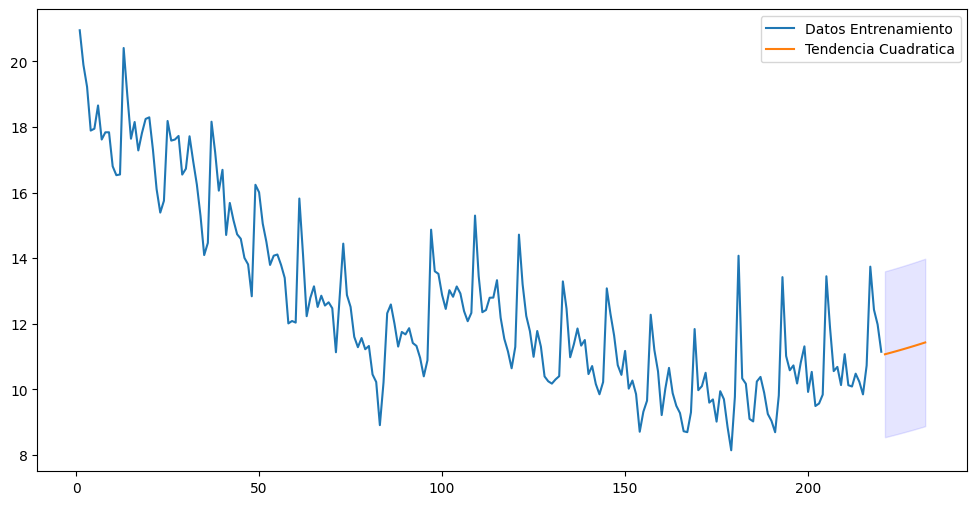

In [28]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia Cuadratica")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [29]:
data

,TD_13ciudades,Ocupados,Desocupados,Inactivos,x,x2
mes,,,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718,1.0,1.0
2001-02-01,19.894213,7037.746,1747.820,4596.805,2.0,4.0
2001-03-01,19.221565,6945.973,1652.823,4807.120,3.0,9.0
2001-04-01,17.888575,6973.079,1519.137,4937.280,4.0,16.0
2001-05-01,17.945654,6994.462,1529.720,4928.911,5.0,25.0
...,...,...,...,...,...,...
2018-12-01,10.725865,10835.398,1301.822,6142.856,216.0,46656.0
2019-01-01,13.739328,10314.438,1642.851,6343.066,217.0,47089.0
2019-02-01,12.427409,10557.917,1498.272,6264.403,218.0,47524.0


### **8. Estimación de la Estacionalidad**

In [18]:
# Para solucionar lo del casteo .. 
data.dtypes # para solucionar lo de abajo

TD_13ciudades    float64
Ocupados         float64
Desocupados      float64
Inactivos        float64
dtype: object

In [17]:
# pruebas 
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)
month_dummies
X = sm.add_constant(month_dummies)
X


,const,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,
2001-01-01,1.0,False,False,False,False,False,False,False,False,False,False,False
2001-02-01,1.0,True,False,False,False,False,False,False,False,False,False,False
2001-03-01,1.0,False,True,False,False,False,False,False,False,False,False,False
2001-04-01,1.0,False,False,True,False,False,False,False,False,False,False,False
2001-05-01,1.0,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-01,1.0,False,False,False,False,False,False,False,False,False,False,True
2019-01-01,1.0,False,False,False,False,False,False,False,False,False,False,False
2019-02-01,1.0,True,False,False,False,False,False,False,False,False,False,False


In [19]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)

# Explicitly convert month dummies to numeric type to fix the error
month_dummies = month_dummies.astype(float) # para arreglar el problema de casteo


# aqui debo hacer el split train / test
y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2787
Date:                Sat, 10 Aug 2024   Prob (F-statistic):              0.989
Time:                        11:37:38   Log-Likelihood:                -1886.0
No. Observations:                 220   AIC:                             3796.
Df Residuals:                     208   BIC:                             3837.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    301.805     29.185      0.0

In [20]:
month_dummies

,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,
2001-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-04-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


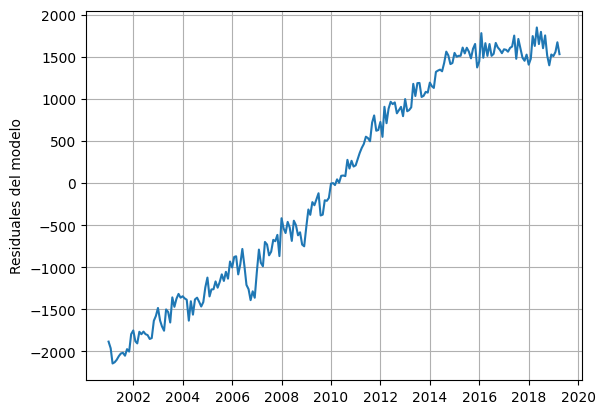

In [21]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

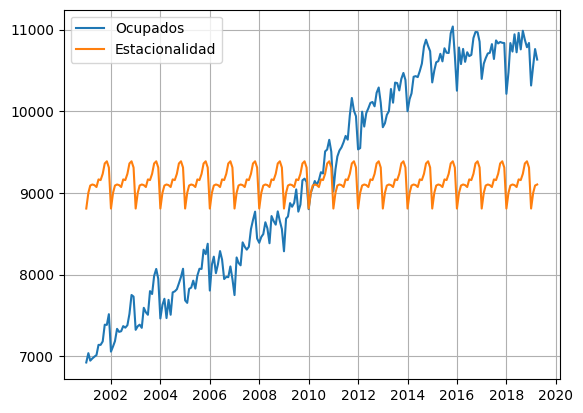

In [22]:
plt.plot(y,label="Ocupados")
plt.plot(season.fittedvalues,label="Estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [23]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=12,freq='MS')

x_for = pd.get_dummies(range_dates.month,drop_first=True)
X_for= sm.add_constant(x_for)
X_for= X_for.astype(float) # modificacion para que corra

In [24]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2019-05-01     9095.089000  6430.527026  11759.650974
2019-06-01     9071.789000  6407.227026  11736.350974
2019-07-01     9164.935167  6500.373193  11829.497140
2019-08-01     9156.633500  6492.071526  11821.195474
2019-09-01     9232.988500  6568.426526  11897.550474
2019-10-01     9359.934944  6695.372971  12024.496918
2019-11-01     9386.702222  6722.140249  12051.264196
2019-12-01     9310.332667  6645.770693  11974.894640
2020-01-01     8808.217632  6147.348746  11469.086517
2020-02-01     9001.037684  6340.168799  11661.906569
2020-03-01     9090.037158  6429.168273  11750.906043
2020-04-01     9102.647316  6441.778431  11763.516201


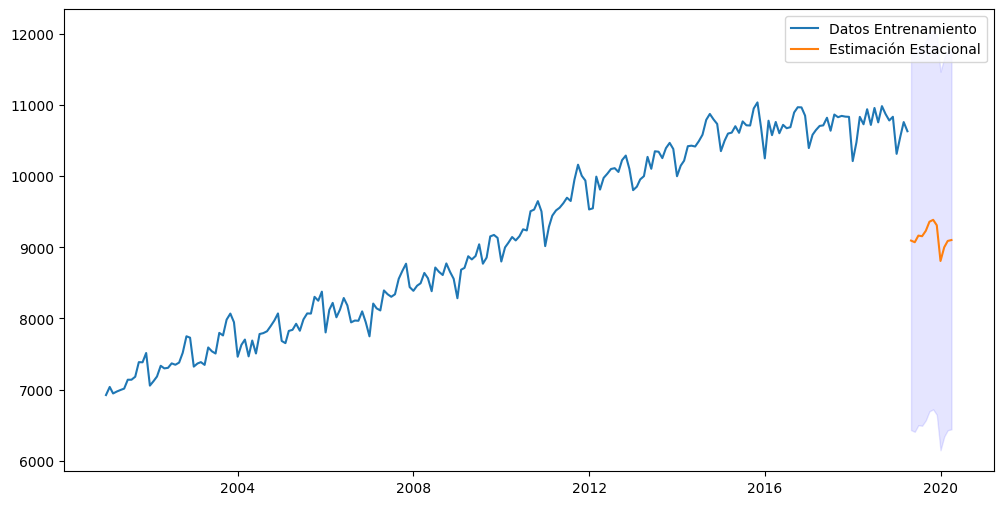

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **9. Tendencia + Estacionalidad**

In [39]:
y = data["TD_13ciudades"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)
# Explicitly convert month dummies to numeric type to fix the error
month_dummies = month_dummies.astype(float) # para arreglar el problema de casteo

X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:          TD_13ciudades   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     174.2
Date:                Sat, 10 Aug 2024   Prob (F-statistic):          2.19e-103
Time:                        10:32:02   Log-Likelihood:                -266.22
No. Observations:                 220   AIC:                             560.4
Df Residuals:                     206   BIC:                             607.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.2179      0.249     85.365      0.0

In [40]:
X

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,,,
2001-01-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-01,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-01,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-04-01,1.0,4.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-01,1.0,5.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-01,1.0,216.0,46656.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-01-01,1.0,217.0,47089.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01,1.0,218.0,47524.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


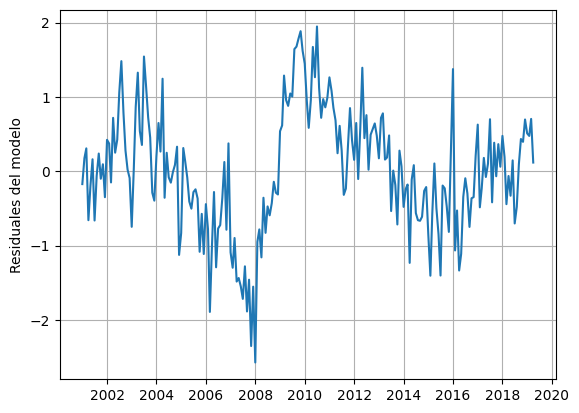

In [41]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()

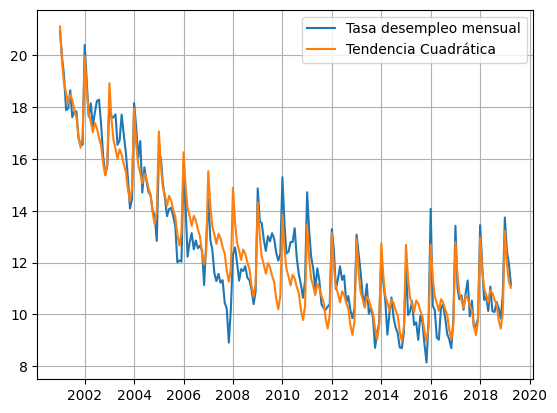

In [46]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(season_pol_2.fittedvalues,label="Tendencia Cuadrática")
plt.legend()
plt.grid()
plt.show()

In [47]:
h=12
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] )

range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

# Explicitly convert month dummies to numeric type to fix the error
x_for_dummies = x_for_dummies.astype(float) # para arreglar el problema de casteo


X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
0,1.0,221.0,48841.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,222.0,49284.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,223.0,49729.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,224.0,50176.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,225.0,50625.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1.0,226.0,51076.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,227.0,51529.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,1.0,228.0,51984.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,229.0,52441.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,230.0,52900.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
dt = season_pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast   lower_95   upper_95
2019-05-01       10.745957   9.016194  12.475720
2019-06-01       11.219334   9.488506  12.950162
2019-07-01       11.128620   9.396699  12.860541
2019-08-01       10.871674   9.138631  12.604716
2019-09-01       10.693725   8.959533  12.427916
2019-10-01       10.118184   8.382815  11.853553
2019-11-01        9.776879   8.040305  11.513453
2019-12-01       10.364458   8.626652  12.102265
2020-01-01       13.571859  11.836180  15.307538
2020-02-01       12.300687  10.563705  14.037669
2020-03-01       11.626377   9.888061  13.364693
2020-04-01       11.389796   9.650115  13.129477


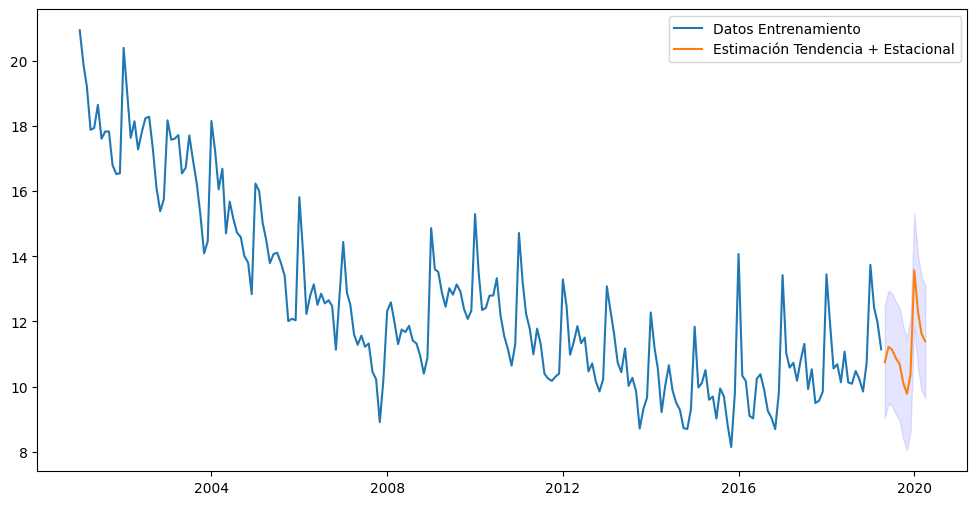

In [49]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **10. Comparación de modelos**

Para realizar la comparación de los modelos se debe usar una metrica de desempeño, en la clase anterior usamos el RMSE, la comparación se debe hacer fuera de muestra.

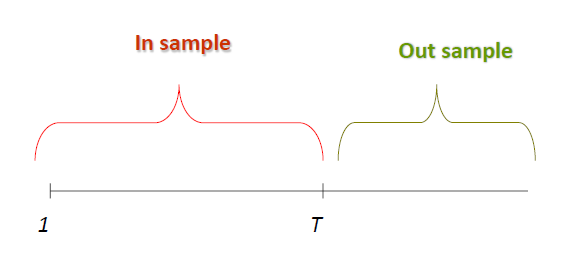

### **11. Evaluación de los supuestos de los residuales**

Para poder hacer uso del modelo y los pronósticos se deben cumplir los supuestos del Teorema de Gauss-Markov sobre los residuales de un modelo de regresión múltiple.

- Probar **Autocorrelación** en los **residuales** con las pruebas Box-Pierce y Ljung-Box para los diferentes rezagos.

- Probar **Homoscedasticidad/Heteroscedasticidad** sobre los residuales, una aproximación para determinar si existe un comportamiento GARCH o ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado. En este caso al ser residuales de una regresión las series ya tienen media cero.

- Probar **Normalidad** sobre los residuales con las pruebas Jarque Bera y Shapiro-Wilk, adicionalmente se pueden realizar las graficas para ver el comportamiento de manera visual.

### **12. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior. 

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.